## Import Libraries

In [225]:
import importlib
import os
from sklearn.model_selection import train_test_split
import pandas as pd 

try:
    importlib.reload(dataloader)
    importlib.reload(model)
    importlib.reload(analysis)
except:
    import dataloader
    import model
    import analysis

## Load Data

In [196]:
data = pd.read_csv(os.path.abspath("all_tested_molecules.csv"))

In [197]:
descriptors = dataloader.get_molecular_descriptors(data, remove_fingerprints=True)
descriptors.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR
0,13.083531,13.083531,0.001173,-0.683140,0.520365,463.542,434.310,463.233188,178,0,...,8,2,10,8,0,1,1,4,1.50330,126.8344
1,12.170097,12.170097,0.066966,-0.066966,0.498564,378.457,360.313,378.115047,136,0,...,6,1,7,7,0,0,0,4,3.48110,104.3507
2,10.905837,10.905837,0.016881,-0.016881,0.382043,477.589,444.325,477.260865,184,0,...,8,2,9,9,0,1,1,5,2.83782,129.8585
3,11.562446,11.562446,0.270607,-0.454447,0.795948,330.609,317.505,328.981818,96,0,...,3,0,5,3,0,0,0,2,4.05510,78.7550
4,12.108866,12.108866,0.086947,-3.251317,0.687618,419.553,402.417,419.043204,140,0,...,6,1,9,5,0,0,0,4,3.37490,110.0965


In [198]:
labels = dataloader.get_labels(data)
labels.head()

,SMILES,ALDH1_inhibition
0,COc1ccccc1CC(NC(C)=O)C(=O)NC1CCN(c2nnnn2-c2ccc...,1
1,O=C(CSc1nc2cccnc2n1Cc1ccccc1)NCc1ccco1,1
2,Cc1cccc2cc(C[NH+](CC3CCCO3)C(c3nnnn3Cc3ccco3)C...,1
3,CCN(CC)c1ccc2c(Cl)c(Br)c(=O)oc2c1,1
4,CS(=O)(=O)N1CCc2cc(-c3csc(NC(=O)Cc4cccs4)n3)ccc21,1


## PCA Analysis

In [199]:
highly_correlated_pairs = analysis.correlation(descriptors)

In [200]:
descriptors = analysis.remove_colinear(descriptors, highly_correlated_pairs)

In [201]:
descriptors = analysis.ScaleDescriptors(descriptors)
descriptors

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,FpDensityMorgan1,...,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP
0,0.861052,0.000628,0.746574,0.492906,0.689213,0.0,0.408481,0.468063,0.521737,0.490537,...,0.500000,0.666667,0.333333,0.600000,0.571429,0.000,0.25,0.125,0.500,0.599490
1,0.788705,0.036201,0.828152,0.466743,0.502704,0.0,0.372711,0.503933,0.485085,0.507246,...,0.666667,0.500000,0.166667,0.400000,0.500000,0.000,0.00,0.000,0.500,0.763359
2,0.688571,0.009121,0.834783,0.326910,0.720005,0.0,0.353608,0.472483,0.517220,0.593043,...,0.666667,0.666667,0.333333,0.533333,0.642857,0.000,0.25,0.125,0.625,0.710061
3,0.740577,0.146305,0.776852,0.823627,0.397819,0.0,0.595167,0.560515,0.427270,0.669565,...,0.333333,0.250000,0.000000,0.266667,0.214286,0.000,0.00,0.000,0.250,0.810917
4,0.783855,0.047004,0.406558,0.693622,0.592788,0.0,0.375299,0.709049,0.275499,0.642512,...,0.500000,0.500000,0.166667,0.533333,0.357143,0.000,0.00,0.000,0.500,0.754560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.828750,0.144162,0.801716,0.459444,0.224037,0.0,0.300484,0.672329,0.313020,0.683887,...,0.166667,0.166667,0.333333,0.266667,0.214286,0.125,0.00,0.125,0.250,0.715047
1996,0.766854,0.084318,0.790821,0.662740,0.259153,0.0,0.574907,0.506586,0.482374,0.588406,...,0.166667,0.333333,0.166667,0.266667,0.142857,0.000,0.00,0.000,0.250,0.703779
1997,0.715574,0.021807,0.825785,0.788935,0.163478,0.0,0.381054,0.651397,0.334407,0.766957,...,0.166667,0.083333,0.166667,0.133333,0.142857,0.000,0.00,0.000,0.250,0.675360
1998,0.839472,0.082301,0.857173,0.541945,0.601532,0.0,0.377174,0.467705,0.522102,0.572174,...,0.500000,0.583333,0.000000,0.466667,0.428571,0.000,0.25,0.125,0.500,0.792350


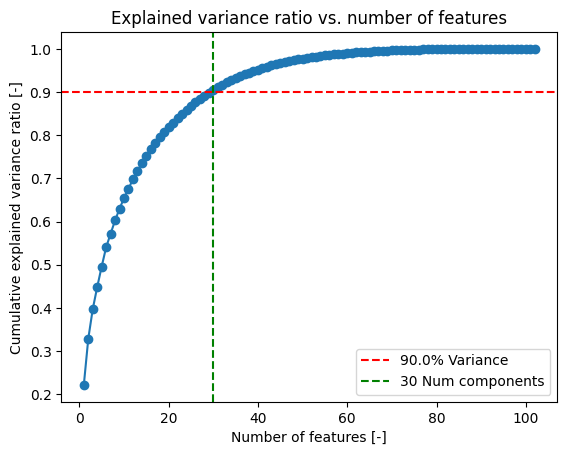

In [202]:
num_components = analysis.plot_variance(descriptors, percentage=0.9)

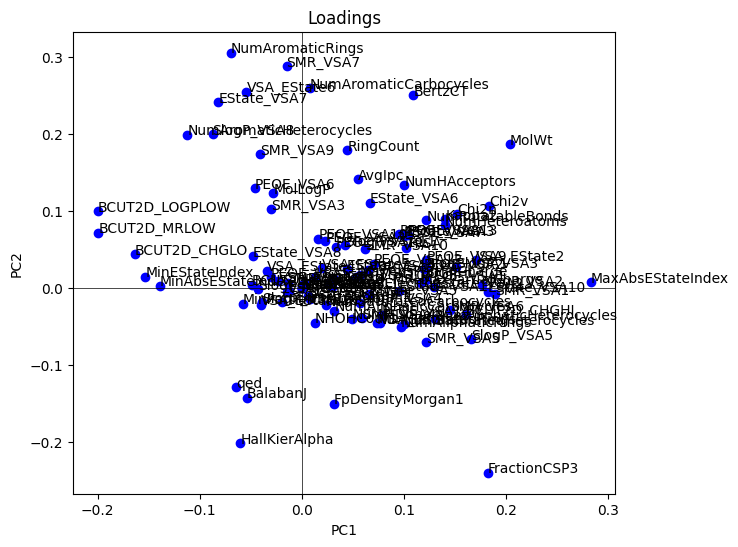

In [203]:
analysis.plot_loadings(descriptors, num_components)

In [204]:
analysis.feature_rankings(descriptors, num_components)

MaxAbsEStateIndex      1.320524e-01
EState_VSA6            1.299743e-01
PEOE_VSA8              1.242521e-01
PEOE_VSA12             1.236753e-01
qed                    1.208143e-01
                           ...     
Ipc                    8.130279e-03
NumRadicalElectrons    2.738738e-17
SMR_VSA8               0.000000e+00
SlogP_VSA9             0.000000e+00
EState_VSA11           0.000000e+00
Length: 102, dtype: float64

## Model training

In [205]:
X_train, X_test, y_train, y_test = train_test_split(descriptors, labels, test_size=0.2, random_state=0)

In [206]:
pipeline = model.train(X_train, y_train, num_components)

Train accuracy = 0.774


Test accuracy = 0.74

Test confusion_matrix
None


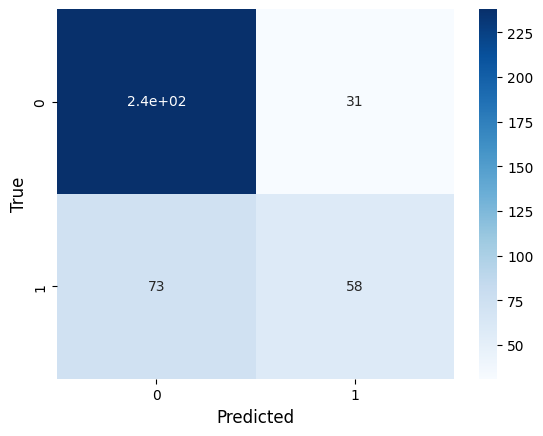

In [207]:
accuracy = model.test(pipeline, X_test, y_test)
print(accuracy)

## Predict new molecules

In [215]:
new_data = pd.read_csv(os.path.abspath("untested_molecules.csv"))

In [216]:
new_descriptors = dataloader.get_molecular_descriptors(new_data, remove_fingerprints=True)
new_descriptors.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR
0,12.089288,12.089288,0.112255,-0.251126,0.349176,379.504,350.272,379.225977,148,0,...,3,2,5,11,0,0,0,2,4.18380,112.7864
1,12.797328,12.797328,0.238255,-3.572690,0.664725,442.537,416.329,442.156243,164,0,...,5,0,8,5,0,1,1,4,2.52822,116.1198
2,12.973159,12.973159,0.116476,-0.893827,0.499889,359.313,345.201,359.091749,134,0,...,6,1,9,5,0,1,1,3,2.48650,90.5691
3,11.709157,11.709157,0.004405,-0.628881,0.247581,358.374,338.214,358.139747,136,0,...,5,2,8,7,0,0,0,2,0.72914,94.4605
4,12.580327,12.580327,0.039856,-4.469682,0.376568,334.729,320.617,334.080823,120,0,...,4,2,9,2,0,1,1,2,2.27030,76.1091


In [227]:
new_labels = dataloader.get_labels(new_data)
new_labels.head()

,SMILES
0,CCCCC/C(=N\NC(=O)CCC(=O)NCc1ccccc1)c1ccccc1
1,Cc1ccc(S(=O)(=O)N2CCC(C(=O)OCC(=O)N3CCc4ccccc4...
2,COc1ccc(N2C(=O)CC(Nc3ccc(F)cc3)C2=O)c([N+](=O)...
3,Cc1cc(C)cc(OCC(=O)O[NH+]=C(N)Cc2ccc([N+](=O)[O...
4,NNC(=O)C=C1CCN(c2ncc(C(F)(F)F)cc2Cl)CC1


In [228]:
new_descriptors = analysis.remove_colinear(new_descriptors, highly_correlated_pairs)

KeyError: "['MinAbsPartialCharge', 'ExactMolWt', 'Chi1n', 'MolMR', 'SlogP_VSA6', 'Kappa1', 'Chi0v', 'Chi3n', 'NumValenceElectrons', 'Chi0n', 'Chi0', 'Chi1', 'Chi1v', 'HeavyAtomMolWt', 'FpDensityMorgan2', 'Chi3v', 'Chi4v', 'Chi4n', 'MaxEStateIndex', 'HeavyAtomCount', 'LabuteASA', 'NOCount'] not found in axis"

In [229]:
new_descriptors = analysis.ScaleDescriptors(new_descriptors)

In [230]:
new_labels = model.predict(pipeline, new_descriptors, new_labels)

In [233]:
new_labels.head(100)

,SMILES,ALDH1_inhibition
7246,Nc1nc(N)nc(CCCc2nc(N)nc(N)n2)n1,0.998276
1605,c1ccc(CN(CC[NH+](Cc2ccccn2)Cc2ccccn2)Cc2ccccn2...,0.995731
8977,Cc1cc(-c2ccccc2)cc(-c2ccccc2)[n+]1C,0.995023
2442,Cc1ccn(-c2cccc(-n3ccc(C)n3)n2)n1,0.994843
9492,c1cncc(C[NH2+]Cc2cccnc2)c1,0.994472
...,...,...
6690,Cc1ccc(-c2nn3nnnc3c3ccccc23)cc1C,0.982407
2603,Cc1cccc(CNc2cc(-c3c(C)noc3C)ncn2)c1,0.982287
1141,CCNc1nc(Cl)nc(NCC)n1,0.982248
7632,Cn1c(SCc2nc3ccccc3[nH]2)nnc1-c1ccccn1,0.981919


In [234]:
new_labels.head(100).to_csv("predicted_molecules.csv", index=False)